In [18]:
# Import statements
import docplex
from docplex.mp.model import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Defining the model class

In [19]:
class PSH(Model):


    def __init__(self):
        super().__init__()

        # Indices
        self.reservoirs = np.arange(3) # For modelling reasons 3 reserviors are implemented, where the last reservoir is the river Kunhar
        self.hydro_units = np.arange(1)
        self.hu_affiliation = {
            0: [],
            1: [0],
            2: []
        }
        self.pumped_storage_units = np.arange(1)
        self.ps_affiliation = {
            0: [0],
            1: [],
            2: []
        }
        self.periods = np.arange(24)
        self.subregions = np.arange(10)
        self.vertices = np.arange(3)

        # Reservoir parameters
        self.initial_volume = {
            0: 1500000,
            1: 1500000,
            2: 10000000
        }
        self.min_terminal_volume = {
            0: 1500000,
            1: 1500000,
            2: 1,
        }
        self.natural_inflow = pd.DataFrame(index=self.reservoirs, columns=self.periods)
        self.natural_inflow.loc[0:,] = 8.66
        self.natural_inflow.loc[1:,] = 86.6
        self.natural_inflow.loc[2:,] = 0
        self.spillage = pd.DataFrame(data=5, index=self.reservoirs, columns=self.periods)

        # Volume limits
        self.volume_limits = pd.DataFrame(index=['max', 'min'], columns=self.reservoirs)
        self.volume_limits.loc['max',0] = 2750000
        self.volume_limits.loc['min',0] = 1000000
        self.volume_limits.loc['max',1] = 2566000
        self.volume_limits.loc['min',1] = 1000000
        self.volume_limits.loc['max',2] = 1000000000
        self.volume_limits.loc['min',2] = 1

        # Getting the energyprices
        self.day = '2024-08-14'
        prices = pd.read_csv('energy prices_Germany_week 33 2024.csv') # Reading the data
        prices.columns = prices.iloc[0] # Fixing wrong headers
        prices.drop(prices.iloc[:2].index, inplace=True)
        prices_day = prices[prices['Date (GMT+2)'].str.contains(self.day, na=False)] # Filter data for the anyzed day
        prices_day.loc[:, 'Day Ahead Auction (DE-LU)'] = pd.to_numeric(prices_day['Day Ahead Auction (DE-LU)'], errors='coerce') # Changing the data type to float
        self.projected_prices = prices_day['Day Ahead Auction (DE-LU)'].values.tolist()

        # Perid length
        self.period_length = 1

        # Pumping consumption of the pumped-storage units
        self.pumping_consumption = {
            0: 9,
        }
        
        # Pumping limits pumped-storage units
        self.ps_discharge_pumping_limits = pd.DataFrame(index=['max', 'min'], columns=self.pumped_storage_units)
        self.ps_discharge_pumping_limits.loc['max':,] = 22
        self.ps_discharge_pumping_limits.loc['min':,] = 10

        # Linearization
        # Hydro units
        self.hu_head_limits = pd.DataFrame(index=['max', 'min'], columns=self.hydro_units)
        self.hu_head_limits.loc['max':,] = 218
        self.hu_head_limits.loc['min':,] = 200

        self.hu_discharge_limits = pd.DataFrame(index=['max', 'min'], columns=self.hydro_units)
        self.hu_discharge_limits.loc['max':,] = 154
        self.hu_discharge_limits.loc['min':,] = 50

        # Pumped-storage units
        self.ps_head_limits = pd.DataFrame(index=['max', 'min'], columns=self.pumped_storage_units)
        self.ps_head_limits.loc['max':,] = 770
        self.ps_head_limits.loc['min':,] = 750

        self.ps_discharge_generation_limits = pd.DataFrame(index=['max', 'min'], columns=self.pumped_storage_units)
        self.ps_discharge_generation_limits.loc['max':,] = 32
        self.ps_discharge_generation_limits.loc['min':,] = 5

        # Empty lists for the vertices
        self.hu_h_vertices = []
        self.hu_q_vertices = []
        self.hu_p_vertices = []

        self.ps_h_vertices = []
        self.ps_q_vertices = []
        self.ps_p_vertices = []

        # Head parameters
        self.hu_head_zero = {
            0: 187.21
        }
        self.hu_head_coefficient = {
            0: 0.000012
        }
        self.ps_head_zero = {
            0: 739.75
        }
        self.ps_head_coefficient = {
            0: 0.000011
        }

        # Efficiencies
        self.hu_effciency = {
            0: 0.9123
        }
        self.ps_efficiency_gen = {
            0: 0.8547
        }
        self.ps_efficiency_pump = {
            0: 0.8975
        }

        # Max Power
        self.hu_max_power = {
            0: 300
        }
        self.ps_max_power = {
            0: 200
        }

    
    # Method to calculate the head vertices for the linearization
    def head_vertices(self, units: list, affiliation: dict, limits: pd.DataFrame) -> list:

        #Defining a 4-dimensional array
        vertice_values = np.zeros([len(self.reservoirs), len(units), len(self.subregions), len(self.vertices)])
        
        for i in self.reservoirs:
            for j in affiliation[i]:

                # Dividing the water head into equally large intervals, that fill the domain
                head_interval = (limits.loc['max',j] - limits.loc['min',j]) / (len(self.subregions) / 2)
                for l in self.subregions:
                    if l % 2 == 0: # Defining the coordonates of 2 trangles in 1 itteration

                        # First triangle
                        vertice_values[i,j,l,0] = limits.loc['min',j] + l / 2 * head_interval # bottom left
                        vertice_values[i,j,l,1] = limits.loc['min',j] + l / 2 * head_interval + head_interval # bottom right
                        vertice_values[i,j,l,2] = vertice_values[i,j,l,0] # top left

                        # Secon triangle
                        vertice_values[i,j,l+1,0] = vertice_values[i,j,l,0] # top left
                        vertice_values[i,j,l+1,1] = vertice_values[i,j,l,1]# top right
                        vertice_values[i,j,l+1,2] = vertice_values[i,j,l,1] # bottom right

        return vertice_values
    

    # Method to calculate the discharge vertrices for the linearization
    def discharge_vertices(self, units: list, affiliation: dict, limits: pd.DataFrame) -> list:

        #Defining a 4-dimensional array
        vertice_values = np.zeros([len(self.reservoirs), len(units), len(self.subregions), len(self.vertices)])

        for i in self.reservoirs:
            for j in affiliation[i]:
                for l in self.subregions:
                    if l % 2 == 0: # Defining the coordonates of 2 triangles in 1 itteration
                        vertice_values[i,j,l,0] = limits.loc['min',j] # bottom left
                        vertice_values[i,j,l,1] = limits.loc['min',j] # bottom right
                        vertice_values[i,j,l,2] = limits.loc['max',j] # top left

                        vertice_values[i,j,l+1,0] = limits.loc['max',j] # top left
                        vertice_values[i,j,l+1,1] = limits.loc['max',j] # top right
                        vertice_values[i,j,l+1,2] = limits.loc['min',j] # bottom right
        
        return vertice_values
    

    # Method to calculate the power vertices for the linearization
    def power_vertices(self, units: list, affiliation: dict, h_vertices: list, q_vertices: list, efficiency: dict) -> list:

        #Defining a 4-dimensional array
        vertice_values = np.zeros([len(self.reservoirs), len(units), len(self.subregions), len(self.vertices)])
        
        for i in self.reservoirs:
            for j in affiliation[i]:
                for l in self.subregions:
                    for r in self.vertices:

                        # Applying the formula
                        vertice_values[i,j,l,r] = 9.81 * (10 ** -3) * efficiency[j] * h_vertices[i,j,l,r] * q_vertices[i,j,l,r]

        return vertice_values
    

    # Method to define the decision variabels
    def define_decision_variables(self):
        self.clear()

        # Reservoir decision variables
        self.volume = self.continuous_var_matrix(self.reservoirs, self.periods, name='volume')
        self.total_discharge = self.continuous_var_matrix(self.reservoirs, self.periods, name='total_discharge')

        # Hydro unit decision variables
        self.hu_discharge = self.continuous_var_cube(self.reservoirs, self.hydro_units, self.periods, name='hu_discharge')
        self.hu_head = self.continuous_var_cube(self.reservoirs, self.hydro_units, self.periods, name='hu_head')
        self.hu_power = self.continuous_var_cube(self.reservoirs, self.hydro_units, self.periods, name='hu_power')
        self.hu_active_subregion = self.binary_var_dict([(i, j, t, l) for i in self.reservoirs for j in self.hydro_units for t in self.periods for l in self.subregions], name='hu_active_subregion')
        self.hu_alpha_coefficient = self.continuous_var_dict([(i, j, t, l, r) for i in self.reservoirs for j in self.hydro_units for t in self.periods for l in self.subregions for r in self.vertices], name='hu_alpha_coefficient')

        # Pumped-storage unit decision variables
        self.ps_active_subregion = self.binary_var_dict([(i, k, t, l) for i in self.reservoirs for k in self.pumped_storage_units for t in self.periods for l in self.subregions], name='ps_active_subregion')
        self.ps_alpha_coefficient = self.continuous_var_dict([(i, k, t, l, r) for i in self.reservoirs for k in self.pumped_storage_units for t in self.periods for l in self.subregions for r in self.vertices], name='ps_alpha_coefficient')
        self.ps_head_gen = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_head_gen')
        self.ps_power_gen = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_power_gen')
        self.ps_power_pump = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_power_pump')
        self.ps_discharge_gen = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_discharge_gen')
        self.ps_discharge_pump = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_discharge_pump')
        self.ps_state_gen = self.binary_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_state_gen')
        self.ps_state_pump = self.binary_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_state_pump')


    # Method that defines the constraints of the model
    def define_contraints(self):
        self.clear_constraints()

        # (2) Water-balance constraint except of first reservoir and first period
        for i in self.reservoirs[1:]:
            for t in self.periods[1:]:
                self.add_constraint(self.volume[i,t] == self.volume[i,t-1] + 3600 * self.period_length * (self.natural_inflow.loc[i,t] - self.total_discharge[i,t] + self.total_discharge[i-1,t] - self.sum(self.ps_discharge_pump[i-1,k,t] for k in self.ps_affiliation[i-1]) + self.sum(self.ps_discharge_pump[i,k,t] for k in self.ps_affiliation[i])))

        # (2) Exception for first reservoir and all periods except of first period
        for t in self.periods[1:]:
            self.add_constraint(self.volume[0,t] == self.volume[0,t-1] + 3600 * self.period_length * (self.natural_inflow.loc[0,t] - self.total_discharge[0,t] + 0 - 0 + self.sum(self.ps_discharge_pump[0,k,t] for k in self.ps_affiliation[0]))) # No inflow from upstream reservoirs and no pumped water to upstream reservoirs for the first reservoir

        # Exceptions for first period ans all reservoirs
        self.add_constraint(self.volume[0,0] == self.initial_volume[0] + 3600 * self.period_length * (self.natural_inflow.loc[0,0] - self.total_discharge[0,0] + 0 - 0 + self.sum(self.ps_discharge_pump[0,k,0] for k in self.ps_affiliation[0]))) # No inflow from upstream reservoirs and no pumped water to upstream reservoirs for the first reservoir
        self.add_constraint(self.volume[1,0] == self.initial_volume[1] + 3600 * self.period_length * (self.natural_inflow.loc[1,0] - self.total_discharge[1,0] + self.total_discharge[1-1,0] - self.sum(self.ps_discharge_pump[0,k,0] for k in self.ps_affiliation[0]) + self.sum(self.ps_discharge_pump[1,k,0] for k in self.ps_affiliation[1]))) # No inflow from
        self.add_constraint(self.volume[2,0] == self.initial_volume[1] + 3600 * self.period_length * (self.natural_inflow.loc[2,0] - self.total_discharge[2,0] + self.total_discharge[2-1,0] - self.sum(self.ps_discharge_pump[1,k,0] for k in self.ps_affiliation[1]) + self.sum(self.ps_discharge_pump[2,k,0] for k in self.ps_affiliation[2])))

        # (3) Total discharge
        for i in self.reservoirs:
            for t in self.periods:
                self.add_constraint(self.total_discharge[i,t] == self.spillage.loc[i,t] + self.sum(self.hu_discharge[i,j,t] for j in self.hu_affiliation[i]) + self.sum(self.ps_discharge_gen[i,k,t] for k in self.ps_affiliation[i]))

        # (4) Water-level limits
        for i in self.reservoirs:
            for t in self.periods:
                self.add_constraint(self.volume[i,t] >= self.volume_limits.loc['min',i])
                self.add_constraint(self.volume[i,t] <= self.volume_limits.loc['max',i])

        # (5) Minimum terminal water level
        self.add_constraints(self.volume[i,len(self.periods)-1] >= self.min_terminal_volume[i] for i in self.reservoirs[:-1])

        # (8) At most one subregion can be active
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.sum(self.hu_active_subregion[i,j,t,l] for l in self.subregions) <= 1)

        # (9) Convex combination coefficients must sum up to 1 or 0
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        self.add_constraint(self.sum(self.hu_alpha_coefficient[i,j,t,l,r] for r in self.vertices) == self.hu_active_subregion[i,j,t,l])

        # (10) Non-negativity condition for convex combination coefficients
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        for r in self.vertices:
                            self.add_constraint(self.hu_alpha_coefficient[i,j,t,l,r] >= 0)

        # (11)-(13) Calculation of linearized water head, discharge, and power output
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.hu_head[i,j,t] == self.sum(self.sum(self.hu_alpha_coefficient[i,j,t,l,r] * self.hu_h_vertices[i,j,l,r] for r in self.vertices) for l in self.subregions)) # (11) water head
                    self.add_constraint(self.hu_discharge[i,j,t] == self.sum(self.sum(self.hu_alpha_coefficient[i,j,t,l,r] * self.hu_q_vertices[i,j,l,r] for r in self.vertices) for l in self.subregions)) # (12) discharge
                    self.add_constraint(self.hu_power[i,j,t] == self.sum(self.sum(self.hu_alpha_coefficient[i,j,t,l,r] * self.hu_p_vertices[i,j,l,r] for r in self.vertices) for l in self.subregions)) # (13) power

        # (14) Max Power constraint
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.hu_power[i,j,t] <= self.hu_max_power[j])

        # (15) Relation between water head and volume
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.hu_head[i,j,t] <= self.hu_head_zero[j] + self.hu_head_coefficient[j] * self.volume[i,t])

        # ----- Modified constraints (8)-(15) for pumped-storage units -----
        # At most one subregion can be active
        for i in self.reservoirs:
            for j in self.ps_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.sum(self.ps_active_subregion[i,j,t,l] for l in self.subregions) <= 1)

        # Convex combination coefficients must sum up to 1 or 0
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        self.add_constraint(self.sum(self.ps_alpha_coefficient[i,k,t,l,r] for r in self.vertices) == self.ps_active_subregion[i,k,t,l])

        # Non-negativity condition for convex combination coefficients
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        for r in self.vertices:
                            self.add_constraint(self.ps_alpha_coefficient[i,k,t,l,r] >= 0)

        # Calculation of linearized water head, discharge, and power output
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.ps_head_gen[i,k,t] == self.sum(self.sum(self.ps_alpha_coefficient[i,k,t,l,r] * self.ps_h_vertices[i,k,l,r] for r in self.vertices) for l in self.subregions)) # water head
                    self.add_constraint(self.ps_discharge_gen[i,k,t] == self.sum(self.sum(self.ps_alpha_coefficient[i,k,t,l,r] * self.ps_q_vertices[i,k,l,r] for r in self.vertices) for l in self.subregions)) # discharge
                    self.add_constraint(self.ps_power_gen[i,k,t] == self.sum(self.sum(self.ps_alpha_coefficient[i,k,t,l,r] * self.ps_p_vertices[i,k,l,r] for r in self.vertices) for l in self.subregions)) # power

        # Relation between water head and volume
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.ps_head_gen[i,k,t] <= self.ps_head_zero[k] + self.ps_head_coefficient[k] * self.volume[i,t])
        
        # Max Power constraint
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.ps_power_gen[i,k,t] <= self.ps_max_power[k])

        # ----- End modified constraints (8)-(15) for pumped-storage units -----

        # (16)-(22) Pumped storage unit constraints
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:

                    # (16) state constraint
                    self.add_constraint(self.ps_state_gen[i,k,t] + self.ps_state_pump[i,k,t] <= 1)

                    # (17) generation constraints
                    self.add_constraint(self.ps_discharge_generation_limits.loc['min',k] * self.ps_state_gen[i,k,t] <= self.ps_discharge_gen[i,k,t])
                    self.add_constraint(self.ps_discharge_generation_limits.loc['max',k] * self.ps_state_gen[i,k,t] >= self.ps_discharge_gen[i,k,t])

                    # (18) Pumping constraints
                    self.add_constraint(self.ps_discharge_pumping_limits.loc['min',k] * self.ps_state_pump[i,k,t] <= self.ps_discharge_pump[i,k,t])
                    self.add_constraint(self.ps_discharge_pumping_limits.loc['max',k] * self.ps_state_pump[i,k,t] >= self.ps_discharge_pump[i,k,t])

                    # (19) Calculating power consumption based on pumped water
                    self.add_constraint(self.ps_power_pump[i,k,t] == self.ps_discharge_pump[i,k,t] * self.pumping_consumption[k] * (1/self.ps_efficiency_pump[k]))

    # Method to define the objective value and to solve the model
    def solve_model(self):
        J = self.sum(self.sum(self.projected_prices[t] * self.period_length * (self.sum(self.hu_power[i,j,t] for j in self.hu_affiliation[i]) + self.sum(self.ps_power_gen[i,k,t] for k in self.ps_affiliation[i]) - self.sum(self.ps_power_pump[i,k,t] for k in self.ps_affiliation[i])) for i in self.reservoirs) for t in self.periods)
        self.maximize(J)
        self.solve()

    
    # Method to create a table displaying the results
    # The first number in the label is always the reservoir index and the second the unit index
    def create_results_table(self):
        results = pd.DataFrame(columns=self.periods+1)

        # Volume
        for i in self.reservoirs:
            for t in self.periods:
                index = f'volume_{i+1}'
                results.loc[index,t+1] = self.volume[i,t].solution_value

        # Spillage
        for i in self.reservoirs:
            for t in self.periods:
                index = f'spillage_{i+1}'
                results.loc[index,t+1] = self.spillage.loc[i,t]

        # Hydro unit discharge
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    index = f'hu_discharge_{i+1}_{j+1}'
                    results.loc[index,t+1] = self.hu_discharge[i,j,t].solution_value

        # Pumped storage unit discharge for power generation
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    index = f'ps_discharge_gen_{i+1}_{k+1}'
                    results.loc[index,t+1] = self.ps_discharge_gen[i,k,t].solution_value

        # Total discharge to downstream reservoirs
        for i in self.reservoirs:
            for t in self.periods:
                index = f'total_discharge_{i+1}'
                results.loc[index,t+1] = self.total_discharge[i,t].solution_value

        # Pumped-storage unit discharge to pump water upstream
        for i in self.reservoirs[1:]:
            if k in self.ps_affiliation[i-1]:
                for t in self.periods:
                    index = f'ps_discharge_pump_{i+1}_{k+1}'
                    results.loc[index,t+1] = self.ps_discharge_pump[i-1,k,t].solution_value

        # Inflow from upstream reservoirs
        for i in self.reservoirs[1:]:
            for t in self.periods:
                index = f'inflow_upstream_{i+1}'
                results.loc[index,t+1] = self.total_discharge[i-1,t].solution_value

        # Inflow of pumped op water
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    index = f'ps_inflow_pump_{i+1}_{k+1}'
                    results.loc[index,t+1] = self.ps_discharge_pump[i,k,t].solution_value

        # Natural inflow
        for i in self.reservoirs:
            for t in self.periods:
                index = f'natural_inflow_{i+1}'
                results.loc[index,t+1] = self.natural_inflow.loc[i,t]

        # Pumped-storage unit state generation
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    index = f'ps_state_gen_{i+1}_{k+1}' 
                    results.loc[index,t+1] = self.ps_state_gen[i,k,t].solution_value

        # Pumped-storage unit state pumping
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    index = f'ps_state_pump_{i+1}_{k+1}' 
                    results.loc[index,t+1] = self.ps_state_pump[i,k,t].solution_value

        # Hydro unit head
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    index = f'hu_head_{i+1}_{j+1}'
                    results.loc[index,t+1] = self.hu_head[i,j,t].solution_value

        # Hydro unit power
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    index = f'hu_power_{i+1}_{j+1}'
                    results.loc[index,t+1] = self.hu_power[i,j,t].solution_value

        # Hydro unit active subregion
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    index = f'hu_active_subregions_{i+1}_{j+1}'
                    results.loc[index,t+1] = [int(self.hu_active_subregion[i,j,t,l].solution_value) for l in self.subregions]

        # Hydro unit alphas
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        if self.hu_active_subregion[i,j,t,l].solution_value == 1:
                            index = f'hu_alpha_{i+1}_{j+1}'
                            results.loc[index,t+1] = [round(self.hu_alpha_coefficient[i,j,t,l,r].solution_value,2) for r in self.vertices]

        # Pumped-storage unit head
        for i in self.reservoirs:
            for j in self.ps_affiliation[i]:
                for t in self.periods:
                    index = f'ps_head_{i+1}_{j+1}'
                    results.loc[index,t+1] = self.ps_head_gen[i,j,t].solution_value

        # Pumped-storage unit power generation
        for i in self.reservoirs:
            for j in self.ps_affiliation[i]:
                for t in self.periods:
                    index = f'ps_power_gen_{i+1}_{j+1}'
                    results.loc[index,t+1] = self.ps_power_gen[i,j,t].solution_value

        # Pumped-storage unit power consumption
        for i in self.reservoirs:
            for j in self.ps_affiliation[i]:
                for t in self.periods:
                    index = f'ps_power_pump_{i+1}_{j+1}'
                    results.loc[index,t+1] = self.ps_power_pump[i,j,t].solution_value

        # Pumped-storage unit active subregion
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    index = f'ps_active_subregions_{i+1}_{k+1}'
                    results.loc[index,t+1] = [int(self.ps_active_subregion[i,k,t,l].solution_value) for l in self.subregions]

        # Pumped-storage unit alpha
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        if self.ps_active_subregion[i,k,t,l].solution_value == 1:
                            index = f'ps_alpha_{i+1}_{k+1}'
                            results.loc[index,t+1] = [round(self.ps_alpha_coefficient[i,k,t,l,r].solution_value,2) for r in self.vertices]

        return results


        

#### Validation the correct calculation of the vertices for the linearization

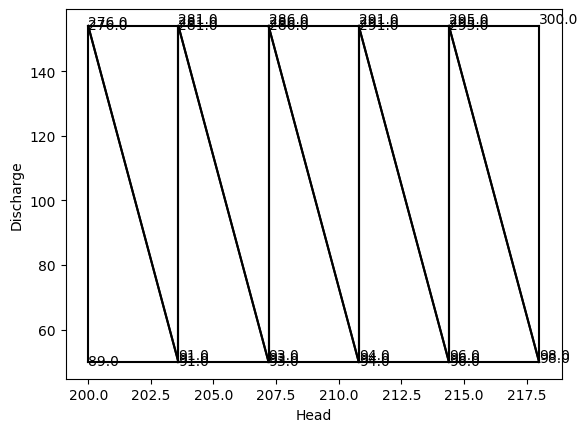

In [20]:
# Creating a model instance
psh = PSH()

# Calculating vertices
psh.hu_h_vertices = psh.head_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_head_limits)
psh.hu_q_vertices = psh.discharge_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_discharge_limits)
psh.hu_p_vertices = psh.power_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_h_vertices, psh.hu_q_vertices, psh.hu_effciency)

# Plotting the subregions in the domain
for i in psh.reservoirs:
    for j in psh.hu_affiliation[i]:

        fig, ax = plt.subplots()

        for l in psh.subregions:

            ax.plot([psh.hu_h_vertices[i,j,l,0], psh.hu_h_vertices[i,j,l,1]], [psh.hu_q_vertices[i,j,l,0], psh.hu_q_vertices[i,j,l,1]], color='black')
            ax.plot([psh.hu_h_vertices[i,j,l,1], psh.hu_h_vertices[i,j,l,2]], [psh.hu_q_vertices[i,j,l,1], psh.hu_q_vertices[i,j,l,2]], color='black')
            ax.plot([psh.hu_h_vertices[i,j,l,2], psh.hu_h_vertices[i,j,l,0]], [psh.hu_q_vertices[i,j,l,2], psh.hu_q_vertices[i,j,l,0]], color='black')

            # Setting the labels
            plt.annotate(round(psh.hu_p_vertices[i,j,l,0],0), xy=(psh.hu_h_vertices[i,j,l,0], psh.hu_q_vertices[i,j,l,0]), xytext=(psh.hu_h_vertices[i,j,l,0], psh.hu_q_vertices[i,j,l,0]-1))
            plt.annotate(round(psh.hu_p_vertices[i,j,l,1],0), xy=(psh.hu_h_vertices[i,j,l,1], psh.hu_q_vertices[i,j,l,1]), xytext=(psh.hu_h_vertices[i,j,l,1], psh.hu_q_vertices[i,j,l,1]+1))
            plt.annotate(round(psh.hu_p_vertices[i,j,l,2],0), xy=(psh.hu_h_vertices[i,j,l,2], psh.hu_q_vertices[i,j,l,2]), xytext=(psh.hu_h_vertices[i,j,l,2], psh.hu_q_vertices[i,j,l,2]))

            ax.set_ylabel('Discharge')
            ax.set_xlabel('Head')

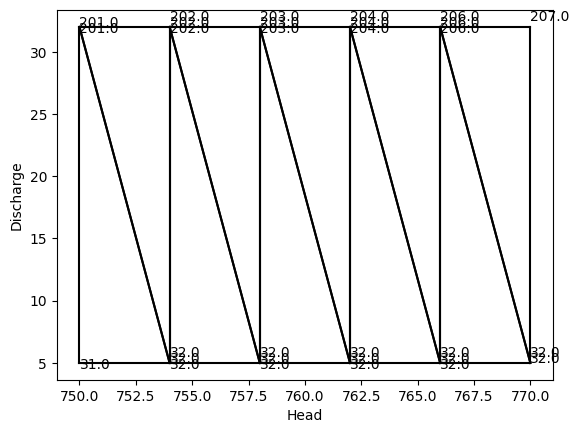

In [21]:
# Creating a model instance
psh = PSH()

# Calculating vertices
psh.ps_h_vertices = psh.head_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_head_limits)
psh.ps_q_vertices = psh.discharge_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_discharge_generation_limits)
psh.ps_p_vertices = psh.power_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_h_vertices, psh.ps_q_vertices, psh.ps_efficiency_gen)

for i in psh.reservoirs:
    for j in psh.ps_affiliation[i]:

        fig, ax = plt.subplots()

        for l in psh.subregions:

            ax.plot([psh.ps_h_vertices[i,j,l,0], psh.ps_h_vertices[i,j,l,1]], [psh.ps_q_vertices[i,j,l,0], psh.ps_q_vertices[i,j,l,1]], color='black')
            ax.plot([psh.ps_h_vertices[i,j,l,1], psh.ps_h_vertices[i,j,l,2]], [psh.ps_q_vertices[i,j,l,1], psh.ps_q_vertices[i,j,l,2]], color='black')
            ax.plot([psh.ps_h_vertices[i,j,l,2], psh.ps_h_vertices[i,j,l,0]], [psh.ps_q_vertices[i,j,l,2], psh.ps_q_vertices[i,j,l,0]], color='black')

            # Setting the labels
            plt.annotate(round(psh.ps_p_vertices[i,j,l,0],0), xy=(psh.ps_h_vertices[i,j,l,0], psh.ps_q_vertices[i,j,l,0]), xytext=(psh.ps_h_vertices[i,j,l,0], psh.ps_q_vertices[i,j,l,0]-0.5))
            plt.annotate(round(psh.ps_p_vertices[i,j,l,1],0), xy=(psh.ps_h_vertices[i,j,l,1], psh.ps_q_vertices[i,j,l,1]), xytext=(psh.ps_h_vertices[i,j,l,1], psh.ps_q_vertices[i,j,l,1]+0.5))
            plt.annotate(round(psh.ps_p_vertices[i,j,l,2],0), xy=(psh.ps_h_vertices[i,j,l,2], psh.ps_q_vertices[i,j,l,2]), xytext=(psh.ps_h_vertices[i,j,l,2], psh.ps_q_vertices[i,j,l,2]))

            ax.set_ylabel('Discharge')
            ax.set_xlabel('Head')

## Solving the model and displaying the results

In [22]:
# Creating a model instance
psh = PSH()

# Calculating the vertices
psh.hu_h_vertices = psh.head_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_head_limits)
psh.hu_q_vertices = psh.discharge_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_discharge_limits)
psh.hu_p_vertices = psh.power_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_h_vertices, psh.hu_q_vertices, psh.hu_effciency)

psh.ps_h_vertices = psh.head_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_head_limits)
psh.ps_q_vertices = psh.discharge_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_discharge_generation_limits)
psh.ps_p_vertices = psh.power_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_h_vertices, psh.ps_q_vertices, psh.ps_efficiency_gen)

# Defining decision variables and constraints
psh.define_decision_variables()
psh.define_contraints()

# Solving the model
psh.solve_model()
print(psh.solve_details)
print(f'The objective vaues is {psh.objective_value} €')

results = psh.create_results_table()
results

status  = integer optimal, tolerance
time    = 1.21714 s.
problem = MILP
gap     = 0.00996361%

The objective vaues is 619892.6442973859 €


,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
volume_1,1513176.0,1526352.0,1539528.0,1552704.0,1565880.0,1579056.0,1478643.202059,1378062.256131,1373238.256131,1386414.256131,...,1769094.256131,1782270.256131,1795446.256131,1808622.256131,1821798.256131,1721781.337241,1621607.542483,1521265.999964,1486824.0,1500000.0
volume_2,1811760.0,2123520.0,2435280.0,2566000.0,2566000.0,2323360.0,2194308.797941,2065425.743869,1840785.743869,1598145.743869,...,2566000.0,2566000.0,2566000.0,2566000.0,2325521.743869,2196074.662759,2066784.457517,1937662.000036,1742640.0,1500000.0
volume_3,1500000.0,1500000.0,1500000.0,1681040.0,1992800.0,2547200.0,3101600.0,3656000.0,4210400.0,4764800.0,...,5038945.743869,5350705.743869,5662465.743869,5974225.743869,6526464.0,7080864.0,7635264.0,8189664.0,8744064.0,9298464.0
spillage_1,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
spillage_2,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
spillage_3,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
hu_discharge_2_1,0,0.0,0,50.288889,86.6,154.0,154.0,154.0,154.0,154.0,...,-0.0,86.6,86.6,86.6,153.399516,154.0,154.0,154.0,154.0,154.0
ps_discharge_gen_1_1,0,0,0,0,0,0,31.552444,31.599152,5.0,0,...,0,0,0,0,0,31.442477,31.486054,31.532651,13.227222,0
total_discharge_1,5.0,5.0,5.0,5.0,5.0,5.0,36.552444,36.599152,10.0,5.0,...,5.0,5.0,5.0,5.0,5.0,36.442477,36.486054,36.532651,18.227222,5.0
total_discharge_2,5.0,5.0,5.0,55.288889,91.6,159.0,159.0,159.0,159.0,159.0,...,5.0,91.6,91.6,91.6,158.399516,159.0,159.0,159.0,159.0,159.0


## Plotting the Data

#### Discharges from the Reservoirs

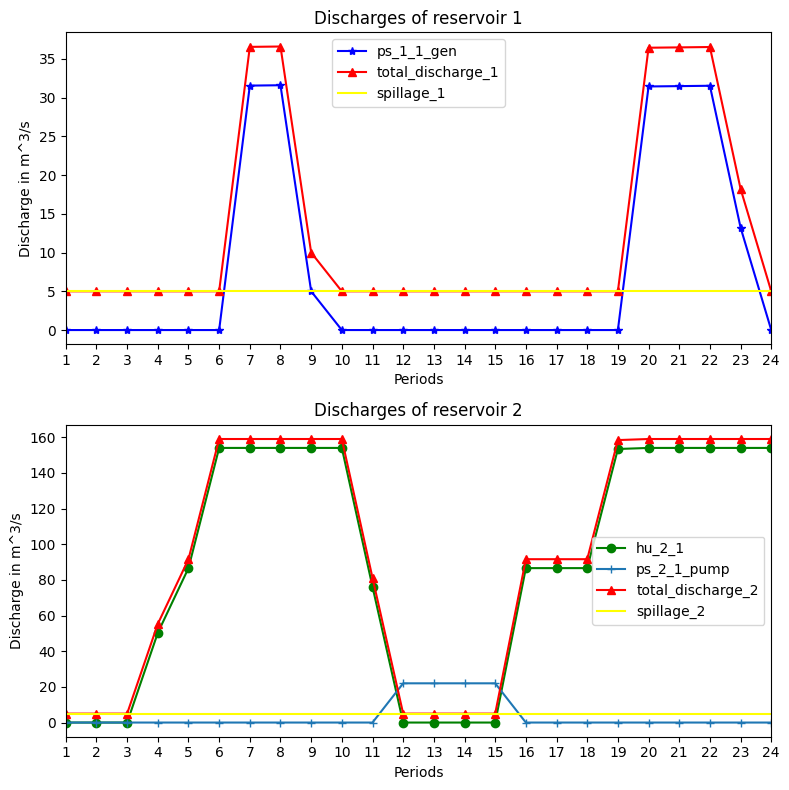

In [23]:
# The first number in the label is always the reservoir index and the second the unit index

fig, ax = plt.subplots(nrows=len(psh.reservoirs)-1, ncols=1, figsize=(8,8))

for i in psh.reservoirs[:-1]:

    # Discharges from hydro units
    for j in psh.hu_affiliation[i]:
        ax[i].plot(psh.periods+1, results.loc[f'hu_discharge_{i+1}_{j+1}'], marker='o', label=f'hu_{i+1}_{j+1}', color='green')

    # Discharges from pumped-storage units to generate power
    for k in psh.ps_affiliation[i]:
        ax[i].plot(psh.periods+1, results.loc[f'ps_discharge_gen_{i+1}_{k+1}'], marker='*', label=f'ps_{i+1}_{k+1}_gen', color='blue')

    # Discharges from pumped-storage units pumped upstream
    if i > 0: # No water can be punped upstream from first reservoir
        for k in psh.ps_affiliation[i-1]:
            ax[i].plot(psh.periods+1, results.loc[f'ps_discharge_pump_{i+1}_{k+1}'], marker='+', label=f'ps_{i+1}_{k+1}_pump')

    # Total discharge downstream and spillage
    ax[i].plot(psh.periods+1, results.loc[f'total_discharge_{i+1}'], label=f'total_discharge_{i+1}', marker='^', color='red')
    ax[i].plot(psh.periods+1, results.loc[f'spillage_{i+1}'], label=f'spillage_{i+1}', color='yellow')

    ax[i].set_title(f'Discharges of reservoir {i+1}')
    ax[i].set_ylabel('Discharge in m^3/s')
    ax[i].set_xlabel('Periods')
    
    ax[i].set_xticks(psh.periods+1)
    ax[i].set_xlim(1, len(psh.periods))

    ax[i].legend()

plt.tight_layout()
plt.savefig('Images/discharge.png', bbox_inches='tight')

#### Power Output over the Planning Horizon

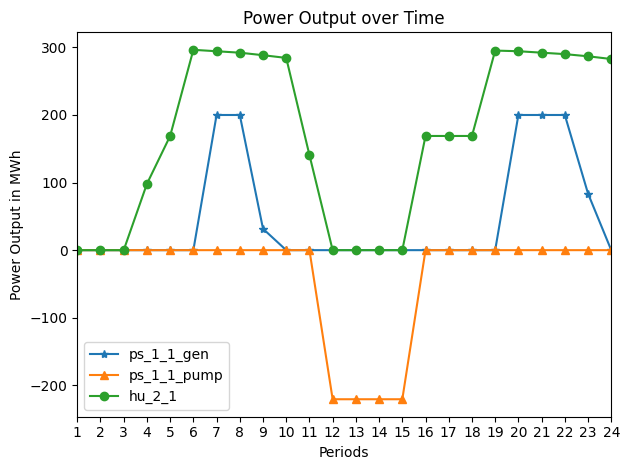

In [24]:
# The first number in the label is always the reservoir index and the second the unit index

fig, ax = plt.subplots()

for i in psh.reservoirs[:-1]:

    # Power generated by hydro units
    for j in psh.hu_affiliation[i]:
        ax.plot(psh.periods+1, results.loc[f'hu_power_{i+1}_{j+1}'], label=f'hu_{i+1}_{j+1}', marker='o')
    
    # Power generated and consumed by pumped-storage units
    for k in psh.ps_affiliation[i]:
        ax.plot(psh.periods+1, results.loc[f'ps_power_gen_{i+1}_{k+1}'], label=f'ps_{i+1}_{k+1}_gen', marker='*')
        ax.plot(psh.periods+1, results.loc[f'ps_power_pump_{i+1}_{k+1}'] * (-1), label=f'ps_{i+1}_{k+1}_pump', marker='^')

    ax.set_title('Power Output over Time')
    ax.set_ylabel('Power Output in MWh')
    ax.set_xlabel('Periods')

    ax.set_xticks(psh.periods+1)
    ax.set_xlim(1, len(psh.periods))

    ax.legend()

plt.tight_layout()
plt.savefig('Images/net_power.png', bbox_inches='tight')

#### Power Production and Determinants over the Planning Horizon

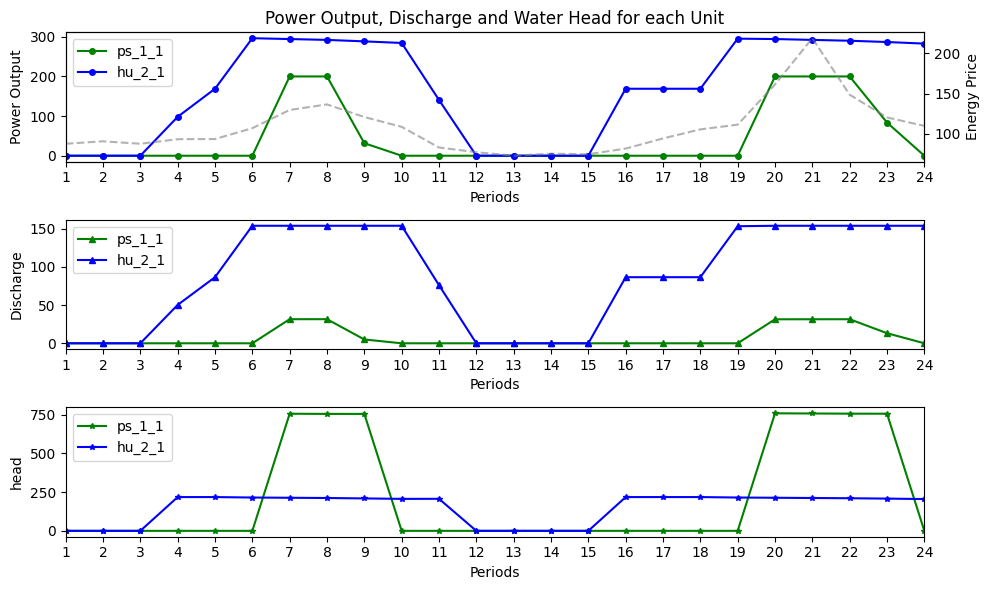

In [25]:
# The first number in the label is always the reservoir index and the second the unit index

fig, ax = plt.subplots(figsize=(10,6), nrows=3)

for i in psh.reservoirs[:-1]:

    # Power, discharge and head of hydro units
    for j in psh.hu_affiliation[i]:
        ax[0].plot(psh.periods+1, results.loc[f'hu_power_{i+1}_{j+1}'], marker='o', markersize=4, label=f'hu_{i+1}_{j+1}', color='blue')
        ax2 = ax[0].twinx()
        ax2.plot(psh.periods+1, psh.projected_prices, linestyle='--', color='gray', alpha=0.6)
        ax2.set_ylabel('Energy Price')
        ax[1].plot(psh.periods+1, results.loc[f'hu_discharge_{i+1}_{j+1}'], marker='^', markersize=4, label=f'hu_{i+1}_{j+1}', color='blue')
        ax[2].plot(psh.periods+1, results.loc[f'hu_head_{i+1}_{j+1}'], marker='*', markersize=4, label=f'hu_{i+1}_{j+1}', color='blue')

    # Power, discharge and head of pumped-storage units
    for k in psh.ps_affiliation[i]:
        ax[0].plot(psh.periods+1, results.loc[f'ps_power_gen_{i+1}_{k+1}'], marker='o', markersize=4, label=f'ps_{i+1}_{k+1}', color='green')
        ax[1].plot(psh.periods+1, results.loc[f'ps_discharge_gen_{i+1}_{k+1}'], marker='^', markersize=4, label=f'ps_{i+1}_{k+1}', color='green')
        ax[2].plot(psh.periods+1, results.loc[f'ps_head_{i+1}_{k+1}'], marker='*', markersize=4, label=f'ps_{i+1}_{k+1}', color='green')
    
    ax[0].set_ylabel('Power Output')
    ax[1].set_ylabel('Discharge')
    ax[2].set_ylabel('head')

    for x in range(3):
        ax[x].set_xlabel('Periods')
        ax[x].set_xticks(psh.periods+1)
        ax[x].set_xlim(1, len(psh.periods))
        ax[x].legend(loc='upper left')
    
    ax[0].set_title('Power Output, Discharge and Water Head for each Unit')

    plt.tight_layout()
    plt.savefig('Images/power_output.png', bbox_inches='tight')


#### Power Output for each Energy Price

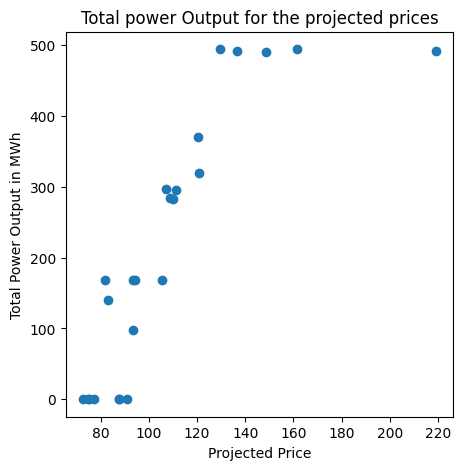

In [26]:
fig, ax = plt.subplots(figsize=(5,5))

power = []

for t in psh.periods:
    power_sum = 0 # power output is summed up over all hydro units and pumped-storage units
    for i in psh.reservoirs:

        # Adding output of hydro units
        for j in psh.hu_affiliation[i]:
            power_sum += psh.hu_power[i,j,t].solution_value

        # Adding output of pumped-storage units
        for k in psh.ps_affiliation[i]:
            power_sum += psh.ps_power_gen[i,k,t].solution_value

    power.append(power_sum)

ax.scatter(psh.projected_prices, power)

ax.set_title('Total power Output for the projected prices')
ax.set_ylabel('Total Power Output in MWh')
ax.set_xlabel('Projected Price')

plt.savefig('Images/power_price.png', bbox_inches='tight')

#### Volume, Inflows and Outflows from and to Reservoirs

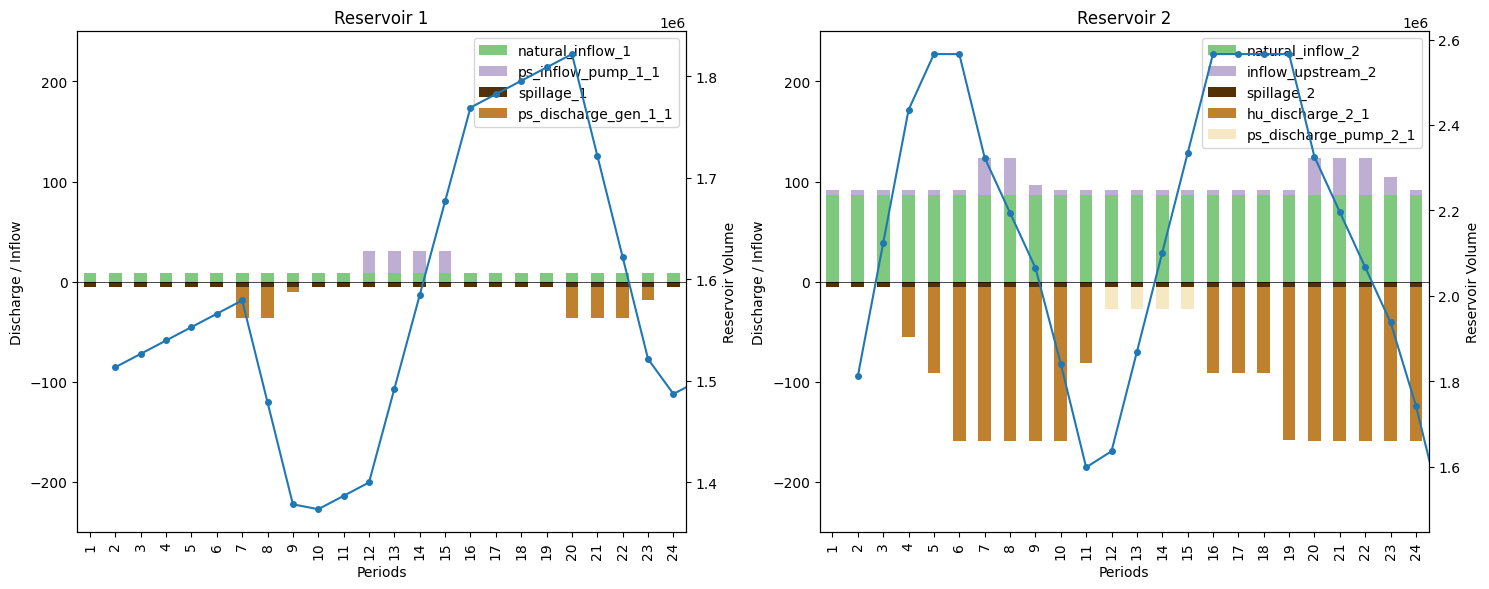

In [27]:
# The first number in the label is always the reservoir index and the second the unit index

fig, ax = plt.subplots(figsize=(15,6), ncols=len(psh.reservoirs)-1)

for i in psh.reservoirs[:-1]:

    # Creating a new data frame with inflows (positive)
    results_filtered_pos = pd.DataFrame()

    # Natural inflows
    results_filtered_pos[f'natural_inflow_{i+1}'] = results.loc[f'natural_inflow_{i+1}']

    # Water pumped upstream
    for k in psh.ps_affiliation[i]:
        results_filtered_pos[f'ps_inflow_pump_{i+1}_{k+1}'] = results.loc[f'ps_inflow_pump_{i+1}_{k+1}']

    # Inflows from upstream reservoirs
    if i > 0:
        results_filtered_pos[f'inflow_upstream_{i+1}'] = results.loc[f'inflow_upstream_{i+1}']

    # Adjusting index
    results_filtered_pos.index = psh.periods+1

    # Creating a new data frame with outflows (negative)
    results_filtered_neg = pd.DataFrame()

    # Spillage
    results_filtered_neg[f'spillage_{i+1}'] = results.loc[f'spillage_{i+1}']

    # Outflows by hydro units
    for j in psh.hu_affiliation[i]:
        results_filtered_neg[f'hu_discharge_{i+1}_{j+1}'] = results.loc[f'hu_discharge_{i+1}_{j+1}']

    # Outflows by pumped-storage units to generate power
    for k in psh.ps_affiliation[i]:
        results_filtered_neg[f'ps_discharge_gen_{i+1}_{k+1}'] = results.loc[f'ps_discharge_gen_{i+1}_{k+1}']

    # Outflows pumped upstream by pumped-storage units
    if i > 0:
        for k in psh.ps_affiliation[i-1]:    
            results_filtered_neg[f'ps_discharge_pump_{i+1}_{k+1}'] = results.loc[f'ps_discharge_pump_{i+1}_{k+1}']
    
    # Multiplying dataframe with -1 to get negative values and adjusting the index
    results_filtered_neg = results_filtered_neg * (-1)
    results_filtered_neg.index = psh.periods+1

    # Adding coloring
    colormap = plt.get_cmap('Accent')
    colors_pos = colormap(np.arange(0,1,0.2))
    colormap = plt.get_cmap('BrBG')
    colors_neg = colormap(np.arange(0,1,0.2))

    # Plotting in- and outflows
    results_filtered_pos.plot(kind='bar', stacked=True, ax=ax[i], color=colors_pos)
    results_filtered_neg.plot(kind='bar', stacked=True, ax=ax[i], color=colors_neg)
    ax[i].axhline(y=0, color='black', linewidth=0.5)

    ax[i].set_ylim(-250, 250)
    
    # Plotting the volume
    ax2 = ax[i].twinx()
    results.T[f'volume_{i+1}'].plot(kind='line', ax=ax2, marker='o', markersize=4)

    ax[i].set_title(f'Reservoir {i+1}')
    ax[i].set_ylabel('Discharge / Inflow')
    ax2.set_ylabel('Reservoir Volume')
    ax[i].set_xlabel('Periods')

    plt.tight_layout()

plt.savefig('Images/Volume.png', bbox_inches='tight')

## Numerical Study

#### Varying accuracy by changig the number of subregions

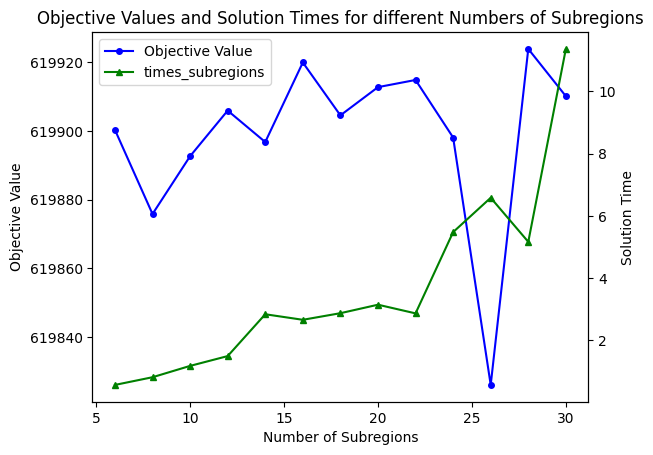

,6,8,10,12,14,16,18,20,22,24,26,28,30
Objective Value,619900.296862,619875.830259,619892.644297,619905.906472,619896.76242,619919.898743,619904.519292,619912.726278,619914.814276,619898.079688,619826.120911,619923.842923,619910.094538
Solution Time,0.570369,0.817658,1.18145,1.496447,2.840066,2.662023,2.874228,3.146867,2.868356,5.478331,6.581311,5.165584,11.362146


In [28]:
# Defining empty lists
objective_values_subregions = []
times_subregions = []

# Defining values for sensitivity analysis
values_subregions = np.arange(6,31,2)

for l in values_subregions:

    # Creating a model instance
    psh_subregions = PSH()

    # Defining number of subregions and solving the model
    psh_subregions.subregions = np.arange(l)

    # Calculating the vertices
    psh_subregions.hu_h_vertices = psh_subregions.head_vertices(psh_subregions.hydro_units, psh_subregions.hu_affiliation, psh_subregions.hu_head_limits)
    psh_subregions.hu_q_vertices = psh_subregions.discharge_vertices(psh_subregions.hydro_units, psh_subregions.hu_affiliation, psh_subregions.hu_discharge_limits)
    psh_subregions.hu_p_vertices = psh_subregions.power_vertices(psh_subregions.hydro_units, psh_subregions.hu_affiliation, psh_subregions.hu_h_vertices, psh_subregions.hu_q_vertices, psh_subregions.hu_effciency)

    psh_subregions.ps_h_vertices = psh_subregions.head_vertices(psh_subregions.pumped_storage_units, psh_subregions.ps_affiliation, psh_subregions.ps_head_limits)
    psh_subregions.ps_q_vertices = psh_subregions.discharge_vertices(psh_subregions.pumped_storage_units, psh_subregions.ps_affiliation, psh_subregions.ps_discharge_generation_limits)
    psh_subregions.ps_p_vertices = psh_subregions.power_vertices(psh_subregions.pumped_storage_units, psh_subregions.ps_affiliation, psh_subregions.ps_h_vertices, psh_subregions.ps_q_vertices, psh_subregions.ps_efficiency_gen)

    # Defining decision variables and constraints
    psh_subregions.define_decision_variables()
    psh_subregions.define_contraints()

    # Solving the model
    psh_subregions.solve_model()

    # Saving results
    objective_values_subregions.append(psh_subregions.objective_value)
    times_subregions.append(psh_subregions.solve_details.time)

# Plotting the results
fig, ax = plt.subplots()
ax.plot(values_subregions, objective_values_subregions, marker='o', markersize=4, label='Objective Value', color='blue')
ax2 = ax.twinx()
ax2.plot(values_subregions, times_subregions, marker='^', markersize=4, label='times_subregions', color='green')

ax.set_title('Objective Values and Solution Times for different Numbers of Subregions')
ax.set_ylabel('Objective Value')
ax.set_xlabel('Number of Subregions')
ax2.set_ylabel('Solution Time')

lines = ax.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax.legend(lines, labels)

plt.savefig('Images/subregions.png', bbox_inches='tight')
plt.show()


# Showing the results in a table
sensitivity_subregions = pd.DataFrame(index=['Objective Value', 'Solution Time'], columns=values_subregions)
sensitivity_subregions.loc['Objective Value':,] = objective_values_subregions
sensitivity_subregions.loc['Solution Time':,] = times_subregions
sensitivity_subregions

#### Varying initial and terminal volumes

In [29]:
# Defining values for the sensitivity analysis
initial_volumes_1 = np.linspace(psh.volume_limits.loc['min',0], psh.volume_limits.loc['max',0], 4)
initial_volumes_2 = np.linspace(psh.volume_limits.loc['min',1], psh.volume_limits.loc['max',1], 4)
terminal_volumes_1 = np.linspace(psh.volume_limits.loc['min',0], psh.volume_limits.loc['max',0], 4)
terminal_volumes_2 = np.linspace(psh.volume_limits.loc['min',1], psh.volume_limits.loc['max',1], 4) 

# Defining empty lists
objective_values_volume = []
labels_volume = []
times_volume = []

# Creating a model instance
psh_volume = PSH()

# Calculating the vertices
psh_volume.hu_h_vertices = psh_volume.head_vertices(psh_volume.hydro_units, psh_volume.hu_affiliation, psh_volume.hu_head_limits)
psh_volume.hu_q_vertices = psh_volume.discharge_vertices(psh_volume.hydro_units, psh_volume.hu_affiliation, psh_volume.hu_discharge_limits)
psh_volume.hu_p_vertices = psh_volume.power_vertices(psh_volume.hydro_units, psh_volume.hu_affiliation, psh_volume.hu_h_vertices, psh_volume.hu_q_vertices, psh_volume.hu_effciency)

psh_volume.ps_h_vertices = psh_volume.head_vertices(psh_volume.pumped_storage_units, psh_volume.ps_affiliation, psh_volume.ps_head_limits)
psh_volume.ps_q_vertices = psh_volume.discharge_vertices(psh_volume.pumped_storage_units, psh_volume.ps_affiliation, psh_volume.ps_discharge_generation_limits)
psh_volume.ps_p_vertices = psh_volume.power_vertices(psh_volume.pumped_storage_units, psh_volume.ps_affiliation, psh_volume.ps_h_vertices, psh_volume.ps_q_vertices, psh_volume.ps_efficiency_gen)

for initial_volume_1 in initial_volumes_1:
    for initial_volume_2 in initial_volumes_2:
        for terminal_volume_1 in terminal_volumes_1:
            for terminal_volume_2 in terminal_volumes_2:

                # Setting the initial volumes
                psh_volume.initial_volume[0] = initial_volume_1
                psh_volume.initial_volume[1] = initial_volume_2

                # Setting the terminal volumes
                psh_volume.min_terminal_volume[0] = terminal_volume_1
                psh_volume.min_terminal_volume[1] = terminal_volume_2

                # Defining decision variables and constraints
                psh_volume.define_decision_variables()
                psh_volume.define_contraints()

                # Solving the model
                psh_volume.solve_model()

                # Saving the resluts
                objective_values_volume.append(psh_volume.objective_value)
                labels_volume.append(f'1I: {initial_volume_1}, 1T: {terminal_volume_1}, 2I: {initial_volume_2}, 2T: {terminal_volume_2}')
                times_volume.append(psh_volume.solve_details.time)

In [30]:
# Printing all results:
for i in range(len(objective_values_volume)):
    print(f'{labels_volume[i]}: {objective_values_volume[i]}')

1I: 1000000.0, 1T: 1000000.0, 2I: 1000000.0, 2T: 1000000.0: 606690.0455992328
1I: 1000000.0, 1T: 1000000.0, 2I: 1000000.0, 2T: 1522000.0: 589709.9160321859
1I: 1000000.0, 1T: 1000000.0, 2I: 1000000.0, 2T: 2044000.0: 563738.5924054954
1I: 1000000.0, 1T: 1000000.0, 2I: 1000000.0, 2T: 2566000.0: 532783.8967329877
1I: 1000000.0, 1T: 1583333.3333333335, 2I: 1000000.0, 2T: 1000000.0: 446665.0145014562
1I: 1000000.0, 1T: 1583333.3333333335, 2I: 1000000.0, 2T: 1522000.0: 428654.72339555953
1I: 1000000.0, 1T: 1583333.3333333335, 2I: 1000000.0, 2T: 2044000.0: 401100.8684333777
1I: 1000000.0, 1T: 1583333.3333333335, 2I: 1000000.0, 2T: 2566000.0: 369517.2658122476
1I: 1000000.0, 1T: 2166666.666666667, 2I: 1000000.0, 2T: 1000000.0: 262477.24072004476
1I: 1000000.0, 1T: 2166666.666666667, 2I: 1000000.0, 2T: 1522000.0: 242108.60426079927
1I: 1000000.0, 1T: 2166666.666666667, 2I: 1000000.0, 2T: 2044000.0: 212804.58894132398
1I: 1000000.0, 1T: 2166666.666666667, 2I: 1000000.0, 2T: 2566000.0: 180281.663

##### Combinations of initial and terminal volumes with negative objective values

In [31]:
# Printing the resluts
print(f'Initial volumes covered for reservoir 1: {initial_volumes_1}')
print(f'Initial volumes covered for reservoir 2: {initial_volumes_2}')
print(f'Terminal volumes covered for reservoir 1: {terminal_volumes_1}')
print(f'Terminal volumes covered for reservoir 2: {terminal_volumes_2}')
print('---------')
print('Combinations with negative objective values:')

# Determining combinations of initial and terminal volumes with negative objective values and saving them in a dictionary
negative_objective_values = {}
for i in range(len(objective_values_volume)):
    if objective_values_volume[i] <= 0:
        negative_objective_values[labels_volume[i]] = objective_values_volume[i]

# Printing the dictionary
for i in range(len(negative_objective_values)):
    print(f'{list(negative_objective_values.keys())[i]}: {negative_objective_values[list(negative_objective_values.keys())[i]]}')

Initial volumes covered for reservoir 1: [1000000.         1583333.33333333 2166666.66666667 2750000.        ]
Initial volumes covered for reservoir 2: [1000000. 1522000. 2044000. 2566000.]
Terminal volumes covered for reservoir 1: [1000000.         1583333.33333333 2166666.66666667 2750000.        ]
Terminal volumes covered for reservoir 2: [1000000. 1522000. 2044000. 2566000.]
---------
Combinations with negative objective values:
1I: 1000000.0, 1T: 2750000.0, 2I: 1000000.0, 2T: 2044000.0: -5299.6624373769155
1I: 1000000.0, 1T: 2750000.0, 2I: 1000000.0, 2T: 2566000.0: -40004.186309067256
1I: 1000000.0, 1T: 2750000.0, 2I: 1522000.0, 2T: 2566000.0: -10879.606548101096


##### Worst Case

In [32]:
# Setting the initial volumes
psh_volume.initial_volume[0] = 1000000
psh_volume.initial_volume[1] = 1000000

# Setting the terminal volumes
psh_volume.min_terminal_volume[0] = 2750000
psh_volume.min_terminal_volume[1] = 2566000

psh_volume.define_decision_variables()
psh_volume.define_contraints()
psh_volume.solve_model()
psh_volume.create_results_table()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
volume_1,1092376.0,1184752.0,1277128.0,1369504.0,1461880.0,1554256.0,1608255.350476,1621431.350476,1713807.350476,1806183.350476,...,2268063.350476,2360439.350476,2452815.350476,2545191.350476,2637567.350476,2650743.350476,2552072.0,2565248.0,2657624.0,2750000.0
volume_2,1232560.0,1465120.0,1697680.0,1930240.0,2162800.0,2215360.0,1931896.649524,1689256.649524,1367416.649524,1118080.0,...,2280880.0,2513440.0,2566000.0,2566000.0,2566000.0,2323360.0,2192567.350476,2100880.0,2333440.0,2566000.0
volume_3,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1180000.0,1734400.0,2288800.0,2843200.0,3325096.649524,...,3325096.649524,3325096.649524,3505096.649524,3737656.649524,3970216.649524,4524616.649524,5079016.649524,5482464.0,5482464.0,5482464.0
spillage_1,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
spillage_2,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
spillage_3,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
hu_discharge_2_1,0,0,0,0,0,50.0,154.0,154.0,154.0,133.86018,...,0,0,50.0,64.6,64.6,154.0,154.0,112.068708,0,0
ps_discharge_gen_1_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,31.068708,0,0,0
total_discharge_1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,36.068708,5.0,5.0,5.0
total_discharge_2,5.0,5.0,5.0,5.0,5.0,55.0,159.0,159.0,159.0,138.86018,...,5.0,5.0,55.0,69.6,69.6,159.0,159.0,117.068708,5.0,5.0


##### Combinations of initial and terminal volumes with highest objective values

In [33]:
top5 = np.argsort(objective_values_volume)[-5:]
for i in top5:
    print(f'{labels_volume[i]}: {objective_values_volume[i]}')

1I: 2750000.0, 1T: 1000000.0, 2I: 2044000.0, 2T: 1522000.0: 1051101.4873123914
1I: 2750000.0, 1T: 1000000.0, 2I: 2566000.0, 2T: 2044000.0: 1053469.7012518626
1I: 2750000.0, 1T: 1000000.0, 2I: 2044000.0, 2T: 1000000.0: 1054362.3845727416
1I: 2750000.0, 1T: 1000000.0, 2I: 2566000.0, 2T: 1522000.0: 1076144.573221096
1I: 2750000.0, 1T: 1000000.0, 2I: 2566000.0, 2T: 1000000.0: 1085032.6274957994


##### Best case

In [34]:
# Setting the initial volumes
psh_volume.initial_volume[0] = 2750000
psh_volume.initial_volume[1] = 2566000

# Setting the terminal volumes
psh_volume.min_terminal_volume[0] = 1000000
psh_volume.min_terminal_volume[1] = 1000000

psh_volume.define_decision_variables()
psh_volume.define_contraints()
psh_volume.solve_model()
psh_volume.create_results_table()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
volume_1,2651492.266878,2552822.150936,2453989.384499,2355009.539308,2255865.679627,2156557.533677,2057084.829226,1956975.569096,1856866.308965,1756755.177693,...,1793306.211597,1806482.211597,1706439.779818,1605728.94588,1505360.813582,1404824.608092,1303505.777216,1202637.661752,1101318.830876,1000000.0
volume_2,2566000.0,2435206.115942,2566000.0,2566000.0,2566000.0,2435844.14595,2305852.850401,2176498.110531,2047143.370662,1917790.501934,...,2337894.901554,2095254.901554,1965833.333333,1837080.167271,1707984.299569,1579056.505059,1450911.335935,1322315.451399,1194170.282275,1066025.113151
volume_3,2989443.733122,3543843.733122,3836818.615501,4260734.460692,4684814.320373,5239214.320373,5793614.320373,6348014.320373,6902414.320373,7456814.320373,...,8624838.886849,9179238.886849,9733638.886849,10288038.886849,10842438.886849,11396838.886849,11951238.886849,12505638.886849,13060038.886849,13614438.886849
spillage_1,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
spillage_2,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
spillage_3,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
hu_discharge_2_1,117.623259,154.0,81.381912,117.754401,117.799961,154.0,154.0,154.0,154.0,154.0,...,70.451268,154.0,154.0,154.0,154.0,154.0,154.0,154.0,154.0,154.0
ps_discharge_gen_1_1,31.023259,31.068366,31.113546,31.154401,31.199961,31.245596,31.291307,31.468128,31.468128,31.468648,...,0,0,31.449564,31.635232,31.540037,31.586724,31.80412,31.678921,31.80412,31.80412
total_discharge_1,36.023259,36.068366,36.113546,36.154401,36.199961,36.245596,36.291307,36.468128,36.468128,36.468648,...,5.0,5.0,36.449564,36.635232,36.540037,36.586724,36.80412,36.678921,36.80412,36.80412
total_discharge_2,122.623259,159.0,86.381912,122.754401,122.799961,159.0,159.0,159.0,159.0,159.0,...,75.451268,159.0,159.0,159.0,159.0,159.0,159.0,159.0,159.0,159.0


#### Varying the natural inflows

In months with the highest snowmelt the natural inflows to the lower reservoir far exceed the max. discharge of the hydro unit. Therefore, a bypass is assumed were excess water can pass the system. Without the bypass the max. volume of the reservoir are exceeded. The natural inflow to the lower reservoir will be set to 154 ${m^{3}}/{s}$ (max. discharge hydro unit). As usual the natural inflow to the upper reservoir will be calculated by dividing the natural inflows of the lower reservoir by 10.

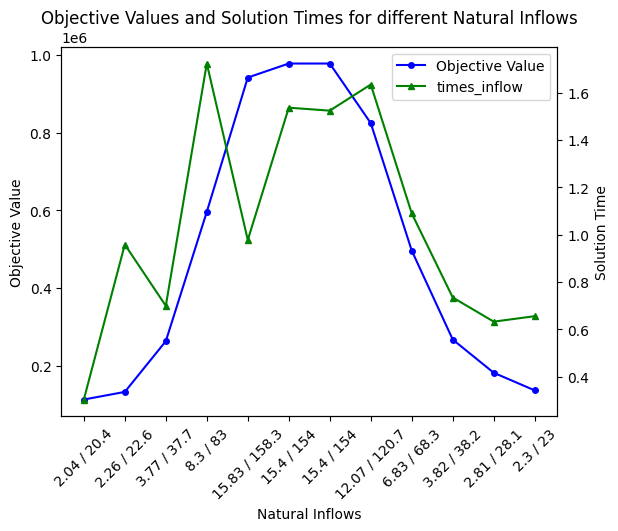

,2.04 / 20.4,2.26 / 22.6,3.77 / 37.7,8.3 / 83,15.83 / 158.3,15.4 / 154,15.4 / 154,12.07 / 120.7,6.83 / 68.3,3.82 / 38.2,2.81 / 28.1,2.3 / 23
Objective Value,112657.139315,132278.517826,263019.71019,596298.663488,942408.695617,978480.262851,978480.262851,824841.526194,496287.781671,267150.117189,181590.058935,136195.827587
Solution Time,0.304182,0.95834,0.699592,1.722294,0.977594,1.535961,1.5234,1.633654,1.089624,0.734743,0.632856,0.655981


In [35]:
# Defining empty lists
objective_values_inflow = []
times_inflow = []
net_power_inflow = []

# Defining values für the sensitivity analysis
inflows_lower = [20.4, 22.6, 37.7, 83, 158.3, 232.6, 198.7, 120.7, 68.3, 38.2, 28.1, 23] # From hydrological data from nasir et al
inflows_upper = [inflow / 10 for inflow in inflows_lower]

# Creating a model instance
psh_inflow = PSH()

# Calculating the vertices
psh_inflow.hu_h_vertices = psh_inflow.head_vertices(psh_inflow.hydro_units, psh_inflow.hu_affiliation, psh_inflow.hu_head_limits)
psh_inflow.hu_q_vertices = psh_inflow.discharge_vertices(psh_inflow.hydro_units, psh_inflow.hu_affiliation, psh_inflow.hu_discharge_limits)
psh_inflow.hu_p_vertices = psh_inflow.power_vertices(psh_inflow.hydro_units, psh_inflow.hu_affiliation, psh_inflow.hu_h_vertices, psh_inflow.hu_q_vertices, psh_inflow.hu_effciency)

psh_inflow.ps_h_vertices = psh_inflow.head_vertices(psh_inflow.pumped_storage_units, psh_inflow.ps_affiliation, psh_inflow.ps_head_limits)
psh_inflow.ps_q_vertices = psh_inflow.discharge_vertices(psh_inflow.pumped_storage_units, psh_inflow.ps_affiliation, psh_inflow.ps_discharge_generation_limits)
psh_inflow.ps_p_vertices = psh_inflow.power_vertices(psh_inflow.pumped_storage_units, psh_inflow.ps_affiliation, psh_inflow.ps_h_vertices, psh_inflow.ps_q_vertices, psh_inflow.ps_efficiency_gen)


for i in range(len(inflows_lower)):
    
    # Setting the initial volumes
    psh_inflow.natural_inflow.loc[0:,] = inflows_upper[i]
    psh_inflow.natural_inflow.loc[1:,] = inflows_lower[i]

    # Defining decision variables and constraints
    psh_inflow.define_decision_variables()
    psh_inflow.define_contraints()

    # Solving the model
    solution = psh_inflow.solve_model()

    # Saving the results
    try:
        objective_values_inflow.append(psh_inflow.objective_value)
        times_inflow.append(psh_inflow.solve_details.time)
        power_hu = [psh_inflow.hu_power[i,j,t].solution_value for i in psh_inflow.reservoirs for j in psh_inflow.hu_affiliation[i] for t in psh_inflow.periods]
        power_gen_ps = [psh_inflow.ps_power_gen[i,k,t].solution_value for i in psh_inflow.reservoirs for k in psh_inflow.ps_affiliation[i] for t in psh_inflow.periods]
        power_pump_ps = [psh_inflow.ps_power_pump[i,k,t].solution_value for i in psh_inflow.reservoirs for k in psh_inflow.ps_affiliation[i] for t in psh_inflow.periods]
        net_power_inflow.append([power_hu[t] + power_gen_ps[t] - power_pump_ps[t] for t in psh_inflow.periods])

    except:

        # Resetting the initial volumes
        inflows_lower[i] = psh_inflow.hu_discharge_limits.loc['max',0]
        inflows_upper[i] = inflows_lower[i] / 10

        psh_inflow.natural_inflow.loc[0:,] = inflows_upper[i]
        psh_inflow.natural_inflow.loc[1:,] = inflows_lower[i]

        # Defining decision variables and constraints
        psh_inflow.define_decision_variables()
        psh_inflow.define_contraints()

        # Solving the model
        solution = psh_inflow.solve_model()

        # Saving the results
        objective_values_inflow.append(psh_inflow.objective_value)
        times_inflow.append(psh_inflow.solve_details.time)
        power_hu = [psh_inflow.hu_power[i,j,t].solution_value for i in psh_inflow.reservoirs for j in psh_inflow.hu_affiliation[i] for t in psh_inflow.periods]
        power_gen_ps = [psh_inflow.ps_power_gen[i,k,t].solution_value for i in psh_inflow.reservoirs for k in psh_inflow.ps_affiliation[i] for t in psh_inflow.periods]
        power_pump_ps = [psh_inflow.ps_power_pump[i,k,t].solution_value for i in psh_inflow.reservoirs for k in psh_inflow.ps_affiliation[i] for t in psh_inflow.periods]
        net_power_inflow.append([power_hu[t] + power_gen_ps[t] - power_pump_ps[t] for t in psh_inflow.periods])

# Plotting the results
fig, ax = plt.subplots()

# Defining the x labels as combination from the inflows by the upper and lower reservoirs
x_labels = [f'{round(inflows_upper[n],2)} / {round(inflows_lower[n],2)}' for n in range(len(inflows_lower))]

ax.plot(np.arange(12), objective_values_inflow, marker='o', markersize=4, label='Objective Value', color='blue')
ax2 = ax.twinx()
ax2.plot(np.arange(12), times_inflow, marker='^', markersize=4, label='times_inflow', color='green')

ax.set_title('Objective Values and Solution Times for different Natural Inflows')
ax.set_ylabel('Objective Value')
ax.set_xlabel('Natural Inflows')
ax2.set_ylabel('Solution Time')
ax.set_xticks(np.arange(12))
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', labelrotation=45)

lines = ax.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax.legend(lines, labels)

plt.savefig('Images/inflows.png', bbox_inches='tight')
plt.show()

# Showing the results in a table
sensitivity_inflow = pd.DataFrame(index=['Objective Value', 'Solution Time'], columns=x_labels)
sensitivity_inflow.loc['Objective Value':,] = objective_values_inflow
sensitivity_inflow.loc['Solution Time':,] = times_inflow
sensitivity_inflow

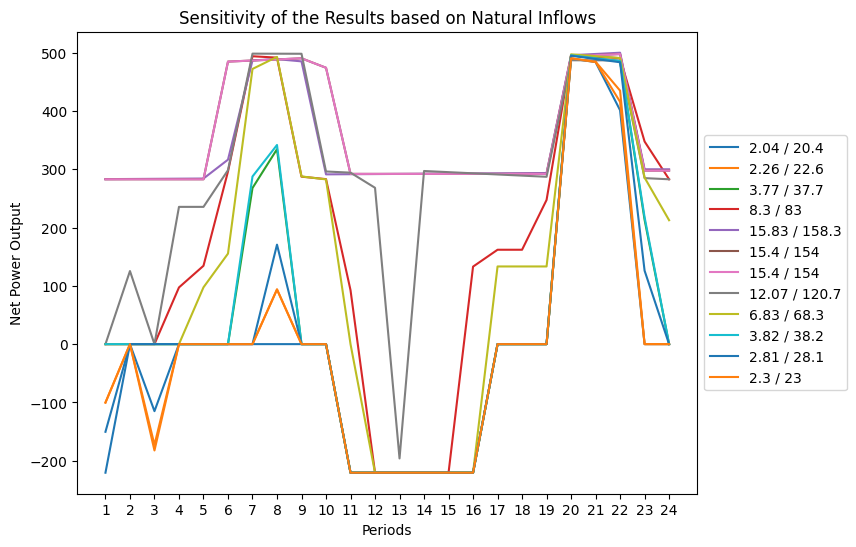

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
for i in range(len(net_power_inflow)):
    ax.plot(psh_inflow.periods+1, net_power_inflow[i], label=x_labels[i])

ax.set_title('Sensitivity of the Results based on Natural Inflows')
ax.set_xlabel('Periods')
ax.set_ylabel('Net Power Output')
ax.set_xticks(psh_inflow.periods+1)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))  

plt.savefig('Images/inflow_sensitivity.png', bbox_inches='tight')


#### Varying the spillage

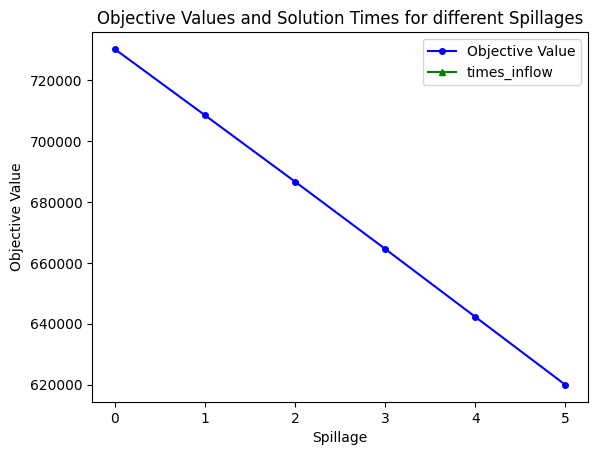

,0,1,2,3,4,5
Objective Value,730314.863429,708568.990692,686721.739668,664605.18235,642259.479584,619892.644297
Solution Time,1.35424,1.745523,1.276505,2.362467,1.703228,1.467755


In [37]:
# Defining empty lists
objectice_values_spillage = []
times_spillage = []

# Defining values for the sensitvity analysis
spillages = np.arange(0,6,1)

for spillage in spillages:

    # Creating a model instance
    psh_spillage = PSH()

    # Setting the initial volumes
    psh_spillage.spillage = pd.DataFrame(data=spillage, index=psh_spillage.reservoirs, columns=psh_spillage.periods)

    # Calculating the vertices
    psh_spillage.hu_h_vertices = psh_spillage.head_vertices(psh_spillage.hydro_units, psh_spillage.hu_affiliation, psh_spillage.hu_head_limits)
    psh_spillage.hu_q_vertices = psh_spillage.discharge_vertices(psh_spillage.hydro_units, psh_spillage.hu_affiliation, psh_spillage.hu_discharge_limits)
    psh_spillage.hu_p_vertices = psh_spillage.power_vertices(psh_spillage.hydro_units, psh_spillage.hu_affiliation, psh_spillage.hu_h_vertices, psh_spillage.hu_q_vertices, psh_spillage.hu_effciency)

    psh_spillage.ps_h_vertices = psh_spillage.head_vertices(psh_spillage.pumped_storage_units, psh_spillage.ps_affiliation, psh_spillage.ps_head_limits)
    psh_spillage.ps_q_vertices = psh_spillage.discharge_vertices(psh_spillage.pumped_storage_units, psh_spillage.ps_affiliation, psh_spillage.ps_discharge_generation_limits)
    psh_spillage.ps_p_vertices = psh_spillage.power_vertices(psh_spillage.pumped_storage_units, psh_spillage.ps_affiliation, psh_spillage.ps_h_vertices, psh_spillage.ps_q_vertices, psh_spillage.ps_efficiency_gen)

    # Defining decision variables and constraints
    psh_spillage.define_decision_variables()
    psh_spillage.define_contraints()

    # Solving the model
    psh_spillage.solve_model()

    # Saving the Results
    objectice_values_spillage.append(psh_spillage.objective_value)
    times_spillage.append(psh_spillage.solve_details.time)

    # Checking if the pumping capabilities of the pumped-storage units are used
    pumping_state = [psh_spillage.ps_state_pump[i,k,t].solution_value for i in psh_spillage.reservoirs for k in psh_spillage.ps_affiliation[i] for t in psh_spillage.periods]
    pumping_state_sum = np.sum(pumping_state)

# Plotting the results
fig, ax = plt.subplots()

ax.plot(spillages, objectice_values_spillage, marker='o', markersize=4, label='Objective Value', color='blue')

ax.set_title('Objective Values and Solution Times for different Spillages')
ax.set_ylabel('Objective Value')
ax.set_xlabel('Spillage')
ax2.set_ylabel('Periods in Pumping State')

lines = ax.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax.legend(lines, labels)

plt.savefig('Images/spillage.png', bbox_inches='tight')
plt.show()

# Showing the results in a table
sensitivity_spillage = pd.DataFrame(index=['Objective Value', 'Solution Time'], columns=spillages)
sensitivity_spillage.loc['Objective Value':,] = objectice_values_spillage
sensitivity_spillage.loc['Solution Time':,] = times_spillage
sensitivity_spillage

In [38]:
print('Increase in objective values when decreasing the spillage:')
for i in range(5,0,-1):
    increase = sensitivity_spillage.loc['Objective Value',i-1] - sensitivity_spillage.loc['Objective Value',i]
    print(f'{i}->{i-1}: {increase}') 

Increase in objective values when decreasing the spillage:
5->4: 22366.835286584217
4->3: 22345.70276572148
3->2: 22116.557318191277
2->1: 21847.251023638994
1->0: 21745.87273773749


#### Varying the efficiencies

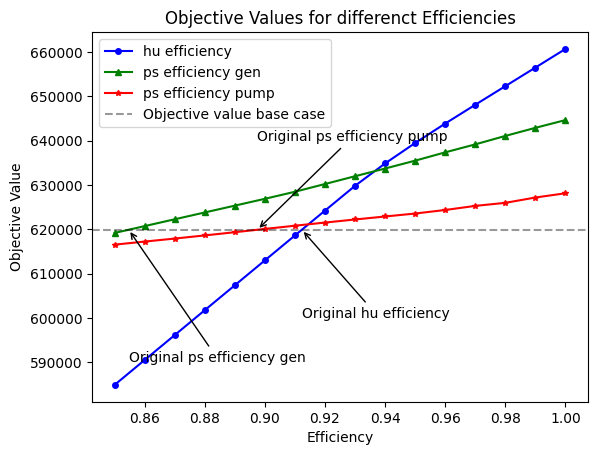

In [39]:
# Creating a model instance
psh_efficiency = PSH()

# Defining values for the sensitivity analysis
efficiencies = np.arange(0.85,1, 0.01)

# Defining empty lists
objective_values_hu = []
objective_values_ps_gen = []
objective_values_ps_pump = []

for efficiency in efficiencies:

    # Hydro unit efficiency
    psh_efficiency.hu_effciency[0] = efficiency

    # Calculating the vertices
    psh_efficiency.hu_h_vertices = psh_efficiency.head_vertices(psh_efficiency.hydro_units, psh_efficiency.hu_affiliation, psh_efficiency.hu_head_limits)
    psh_efficiency.hu_q_vertices = psh_efficiency.discharge_vertices(psh_efficiency.hydro_units, psh_efficiency.hu_affiliation, psh_efficiency.hu_discharge_limits)
    psh_efficiency.hu_p_vertices = psh_efficiency.power_vertices(psh_efficiency.hydro_units, psh_efficiency.hu_affiliation, psh_efficiency.hu_h_vertices, psh_efficiency.hu_q_vertices, psh_efficiency.hu_effciency)

    psh_efficiency.ps_h_vertices = psh_efficiency.head_vertices(psh_efficiency.pumped_storage_units, psh_efficiency.ps_affiliation, psh_efficiency.ps_head_limits)
    psh_efficiency.ps_q_vertices = psh_efficiency.discharge_vertices(psh_efficiency.pumped_storage_units, psh_efficiency.ps_affiliation, psh_efficiency.ps_discharge_generation_limits)
    psh_efficiency.ps_p_vertices = psh_efficiency.power_vertices(psh_efficiency.pumped_storage_units, psh_efficiency.ps_affiliation, psh_efficiency.ps_h_vertices, psh_efficiency.ps_q_vertices, psh_efficiency.ps_efficiency_gen)

    psh_efficiency.define_decision_variables()
    psh_efficiency.define_contraints()
    psh_efficiency.solve_model()

    objective_values_hu.append(psh_efficiency.objective_value)
    
    psh_efficiency.hu_effciency[0] = psh.hu_effciency[0]

    # Pumped-storage unit efficience gen

    psh_efficiency.ps_efficiency_gen[0] = efficiency

    # Calculating the vertices
    psh_efficiency.hu_h_vertices = psh_efficiency.head_vertices(psh_efficiency.hydro_units, psh_efficiency.hu_affiliation, psh_efficiency.hu_head_limits)
    psh_efficiency.hu_q_vertices = psh_efficiency.discharge_vertices(psh_efficiency.hydro_units, psh_efficiency.hu_affiliation, psh_efficiency.hu_discharge_limits)
    psh_efficiency.hu_p_vertices = psh_efficiency.power_vertices(psh_efficiency.hydro_units, psh_efficiency.hu_affiliation, psh_efficiency.hu_h_vertices, psh_efficiency.hu_q_vertices, psh_efficiency.hu_effciency)

    psh_efficiency.ps_h_vertices = psh_efficiency.head_vertices(psh_efficiency.pumped_storage_units, psh_efficiency.ps_affiliation, psh_efficiency.ps_head_limits)
    psh_efficiency.ps_q_vertices = psh_efficiency.discharge_vertices(psh_efficiency.pumped_storage_units, psh_efficiency.ps_affiliation, psh_efficiency.ps_discharge_generation_limits)
    psh_efficiency.ps_p_vertices = psh_efficiency.power_vertices(psh_efficiency.pumped_storage_units, psh_efficiency.ps_affiliation, psh_efficiency.ps_h_vertices, psh_efficiency.ps_q_vertices, psh_efficiency.ps_efficiency_gen)

    psh_efficiency.define_decision_variables()
    psh_efficiency.define_contraints()
    psh_efficiency.solve_model()

    objective_values_ps_gen.append(psh_efficiency.objective_value)
    
    psh_efficiency.ps_efficiency_gen[0] = psh.ps_efficiency_gen[0]
    
    # Pumped-storage unit efficience pump
    psh_efficiency.ps_efficiency_pump[0] = efficiency

    # Calculating the vertices
    psh_efficiency.hu_h_vertices = psh_efficiency.head_vertices(psh_efficiency.hydro_units, psh_efficiency.hu_affiliation, psh_efficiency.hu_head_limits)
    psh_efficiency.hu_q_vertices = psh_efficiency.discharge_vertices(psh_efficiency.hydro_units, psh_efficiency.hu_affiliation, psh_efficiency.hu_discharge_limits)
    psh_efficiency.hu_p_vertices = psh_efficiency.power_vertices(psh_efficiency.hydro_units, psh_efficiency.hu_affiliation, psh_efficiency.hu_h_vertices, psh_efficiency.hu_q_vertices, psh_efficiency.hu_effciency)

    psh_efficiency.ps_h_vertices = psh_efficiency.head_vertices(psh_efficiency.pumped_storage_units, psh_efficiency.ps_affiliation, psh_efficiency.ps_head_limits)
    psh_efficiency.ps_q_vertices = psh_efficiency.discharge_vertices(psh_efficiency.pumped_storage_units, psh_efficiency.ps_affiliation, psh_efficiency.ps_discharge_generation_limits)
    psh_efficiency.ps_p_vertices = psh_efficiency.power_vertices(psh_efficiency.pumped_storage_units, psh_efficiency.ps_affiliation, psh_efficiency.ps_h_vertices, psh_efficiency.ps_q_vertices, psh_efficiency.ps_efficiency_gen)

    psh_efficiency.define_decision_variables()
    psh_efficiency.define_contraints()
    psh_efficiency.solve_model()

    objective_values_ps_pump.append(psh_efficiency.objective_value)

    psh_efficiency.ps_efficiency_pump[0] = psh.ps_efficiency_pump[0]

fig, ax = plt.subplots()
ax.plot(efficiencies, objective_values_hu, label='hu efficiency', marker='o', markersize=4, color='blue')
ax.plot(efficiencies, objective_values_ps_gen, label='ps efficiency gen', marker='^', markersize=4, color='green')
ax.plot(efficiencies, objective_values_ps_pump, label='ps efficiency pump', marker='*', markersize=4, color='red')

ax.annotate('Original hu efficiency', xy=(0.9123, 619892.6442973859), xytext=(0.9123, 600000), arrowprops=dict(facecolor='blue', arrowstyle='->'))
ax.annotate('Original ps efficiency gen', xy=(0.8547, 619892.6442973859), xytext=(0.8547, 590000), arrowprops=dict(facecolor='green', arrowstyle='->'))
ax.annotate('Original ps efficiency pump', xy=(0.8975, 619892.6442973859), xytext=(0.8975, 640000), arrowprops=dict(facecolor='red', arrowstyle='->'))

ax.axhline(619892.6442973859, color='black', alpha=0.4, linestyle='--', label='Objective value base case')

ax.set_title('Objective Values for differenct Efficiencies')
ax.set_xlabel('Efficiency')
ax.set_ylabel('Objective Value')

plt.legend()
plt.savefig('Images/efficiencies.png', bbox_inches='tight')

#### Adding another hydro unit

In [40]:
# Creating a new model instance
psh_unit = PSH()

# Changing / adding necessary parameters
psh_unit.hydro_units = np.arange(2)
psh_unit.hu_affiliation[1] = [0,1]
psh_unit.hu_head_zero[1] = 187.21
psh_unit.hu_head_coefficient[1] = 0.000012
psh_unit.hu_effciency[1] = 0.9123
psh_unit.hu_max_power[1] = 300 

psh_unit.hu_head_limits.loc['max',1] = 218
psh_unit.hu_head_limits.loc['min',1] = 200
psh_unit.hu_discharge_limits.loc['max',1] = 154
psh_unit.hu_discharge_limits.loc['min',1] = 50

# Calculating the vertices
psh_unit.hu_h_vertices = psh_unit.head_vertices(psh_unit.hydro_units, psh_unit.hu_affiliation, psh_unit.hu_head_limits)
psh_unit.hu_q_vertices = psh_unit.discharge_vertices(psh_unit.hydro_units, psh_unit.hu_affiliation, psh_unit.hu_discharge_limits)
psh_unit.hu_p_vertices = psh_unit.power_vertices(psh_unit.hydro_units, psh_unit.hu_affiliation, psh_unit.hu_h_vertices, psh_unit.hu_q_vertices, psh_unit.hu_effciency)

psh_unit.ps_h_vertices = psh_unit.head_vertices(psh_unit.pumped_storage_units, psh_unit.ps_affiliation, psh_unit.ps_head_limits)
psh_unit.ps_q_vertices = psh_unit.discharge_vertices(psh_unit.pumped_storage_units, psh_unit.ps_affiliation, psh_unit.ps_discharge_generation_limits)
psh_unit.ps_p_vertices = psh_unit.power_vertices(psh_unit.pumped_storage_units, psh_unit.ps_affiliation, psh_unit.ps_h_vertices, psh_unit.ps_q_vertices, psh_unit.ps_efficiency_gen)

# Defining decision variables and constraints
psh_unit.define_decision_variables()
psh_unit.define_contraints()

# Solving the model
psh_unit.solve_model()
print(psh_unit.solve_details)
print(f'The objective vaues is {psh_unit.objective_value} €')

status  = integer optimal solution
time    = 1.97153 s.
problem = MILP
gap     = 0%

The objective vaues is 671303.4742176066 €


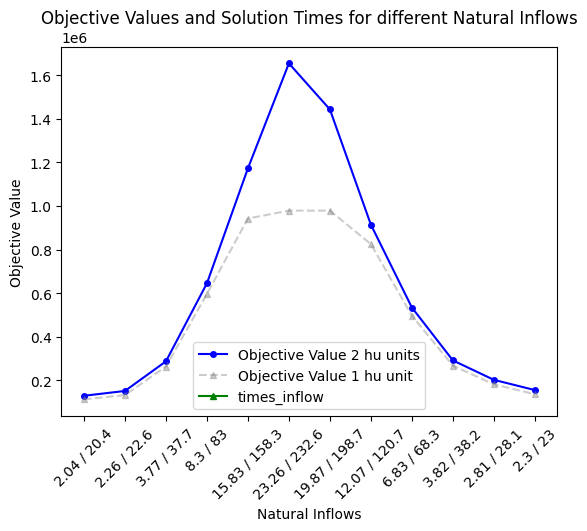

,2.04 / 20.4,2.26 / 22.6,3.77 / 37.7,8.3 / 83,15.83 / 158.3,23.26 / 232.6,19.87 / 198.7,12.07 / 120.7,6.83 / 68.3,3.82 / 38.2,2.81 / 28.1,2.3 / 23
Objective Value 2 Units,129073.934882,151175.26875,286993.735018,645096.905377,1172515.287487,1654291.906596,1442834.614965,914081.29949,533957.257262,291345.658616,202165.31752,155225.081813
Objective Value 1 Unit,112657.139315,132278.517826,263019.71019,596298.663488,942408.695617,978480.262851,978480.262851,824841.526194,496287.781671,267150.117189,181590.058935,136195.827587
Solution Time,0.464028,0.951292,2.089377,19.085212,1.955619,1.500052,1.415982,4.341671,9.640422,2.792227,1.724376,0.971034


In [41]:
# Defining empty lists
objective_values_inflow_unit = []
times_inflow_unit = []

# Defining values für the sensitivity analysis
inflows_lower = [20.4, 22.6, 37.7, 83, 158.3, 232.6, 198.7, 120.7, 68.3, 38.2, 28.1, 23] # From hydrological data from nasir et al
inflows_upper = [inflow / 10 for inflow in inflows_lower]

for i in range(len(inflows_lower)):
    
    # Setting the initial volumes
    psh_unit.natural_inflow.loc[0:,] = inflows_upper[i]
    psh_unit.natural_inflow.loc[1:,] = inflows_lower[i]

    # Defining decision variables and constraints
    psh_unit.define_decision_variables()
    psh_unit.define_contraints()

    # Solving the model
    solution = psh_unit.solve_model()

    # Saving the results
    try:
        objective_values_inflow_unit.append(psh_unit.objective_value)
        times_inflow_unit.append(psh_unit.solve_details.time)

    except:

        # Resetting the initial volumes
        inflows_lower[i] = psh_unit.hu_discharge_limits.loc['max',0]
        inflows_upper[i] = inflows_lower[i] / 10

        psh_unit.natural_inflow.loc[0:,] = inflows_upper[i]
        psh_unit.natural_inflow.loc[1:,] = inflows_lower[i]

        # Defining decision variables and constraints
        psh_unit.define_decision_variables()
        psh_unit.define_contraints()

        # Solving the model
        solution = psh_unit.solve_model()

        # Saving the results
        objective_values_inflow_unit.append(psh_unit.objective_value)
        times_inflow_unit.append(psh_unit.solve_details.time)


# Plotting the results
fig, ax = plt.subplots()

# Defining the x labels as combination from the inflows by the upper and lower reservoirs
x_labels = [f'{round(inflows_upper[n],2)} / {round(inflows_lower[n],2)}' for n in range(len(inflows_lower))]

ax.plot(np.arange(12), objective_values_inflow_unit, marker='o', markersize=4, label='Objective Value 2 hu units', color='blue')
ax.plot(np.arange(12), objective_values_inflow, marker='^', markersize=4, label='Objective Value 1 hu unit', color='gray', alpha=0.4, linestyle='--')

ax.set_title('Objective Values and Solution Times for different Natural Inflows')
ax.set_ylabel('Objective Value')
ax.set_xlabel('Natural Inflows')
ax2.set_ylabel('Solution Time')
ax.set_xticks(np.arange(12))
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', labelrotation=45)

lines = ax.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax.legend(lines, labels)

plt.savefig('Images/inflows_units.png', bbox_inches='tight')
plt.show()

# Showing the results in a table
sensitivity_inflow_unit = pd.DataFrame(index=['Objective Value 2 Units', 'Objective Value 1 Unit', 'Solution Time'], columns=x_labels)
sensitivity_inflow_unit.loc['Objective Value 2 Units':,] = objective_values_inflow_unit
sensitivity_inflow_unit.loc['Objective Value 1 Unit':,] = objective_values_inflow
sensitivity_inflow_unit.loc['Solution Time':,] = times_inflow_unit
sensitivity_inflow_unit